In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import cohen_kappa_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.feature_selection import f_regression
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold

In [77]:
#import data
sample_submission_data = pd.read_csv('sample_submission.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
wine_extra_data = pd.read_csv('WineQT.csv')

In [78]:
print(f'Size of train: {train_data.shape}')
print(f'Size of test: {test_data.shape}')
print(f'Size of sample: {sample_submission_data.shape}')
print(f'Size of extradata: {wine_extra_data.shape}')

Size of train: (2056, 13)
Size of test: (1372, 12)
Size of sample: (1372, 2)
Size of extradata: (1143, 13)


In [75]:
#add extra data to train
train_data = train_data.append(wine_extra_data, ignore_index = True)
train_data = train_data.drop_duplicates(list(train_data.drop(['Id', 'quality'], axis=1)))

In [79]:
X = train_data.drop(['Id', 'quality'], axis=1)
y = train_data.quality

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3074 entries, 0 to 3198
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fixed acidity            3074 non-null   float64
 1   volatile acidity         3074 non-null   float64
 2   citric acid              3074 non-null   float64
 3   residual sugar           3074 non-null   float64
 4   chlorides                3074 non-null   float64
 5   free sulfur dioxide      3074 non-null   float64
 6   total sulfur dioxide     3074 non-null   float64
 7   density                  3074 non-null   float64
 8   pH                       3074 non-null   float64
 9   sulphates                3074 non-null   float64
 10  alcohol                  3074 non-null   float64
 11  acid                     3074 non-null   float64
 12  fixed_acidity_n_density  3074 non-null   float64
 13  fixed_acidity_n_PH       3074 non-null   float64
 14  destiny_regular_sugar   

In [153]:
#separation data
train_data = train_data[~((train_data.quality == 3) | (train_data.quality == 4) | (train_data.quality == 5))]

In [56]:
#selecting_only_some_parameters 
X = X.drop('alcohol', axis=1)

In [65]:
#merge_columns
X['acid'] = X['fixed acidity'] + X['citric acid']
X['fixed_acidity_n_density'] = X['fixed acidity'] + X['density']
#X = X.drop(['fixed acidity', 'citric acid', 'density'], axis=1)

In [66]:
#merge_columns
X['fixed_acidity_n_PH'] = X['fixed acidity'] * X['pH']

In [67]:
#merge_columns
X['destiny_regular_sugar'] = X['density'] / X['free sulfur dioxide']
X['destiny_alcohol'] = X['density'] / X['alcohol']
X['destiny_regular_sugar'] = X['density'] / (X['free sulfur dioxide'] + X['volatile acidity'] + X['fixed acidity'])

In [68]:
#merge_columns
X['less_dioxide'] = X['total sulfur dioxide'] * X['free sulfur dioxide']

In [188]:
#normolize
transformer = Normalizer()
X_norm_list = transformer.transform(X)
X = pd.DataFrame(X_norm_list, columns=list(X))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fixed acidity            2056 non-null   float64
 1   volatile acidity         2056 non-null   float64
 2   citric acid              2056 non-null   float64
 3   residual sugar           2056 non-null   float64
 4   chlorides                2056 non-null   float64
 5   free sulfur dioxide      2056 non-null   float64
 6   total sulfur dioxide     2056 non-null   float64
 7   density                  2056 non-null   float64
 8   pH                       2056 non-null   float64
 9   sulphates                2056 non-null   float64
 10  alcohol                  2056 non-null   float64
 11  acid                     2056 non-null   float64
 12  fixed_acidity_n_density  2056 non-null   float64
dtypes: float64(13)
memory usage: 208.9 KB


In [8]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1
1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8
2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3
3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8
4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5


<AxesSubplot:>

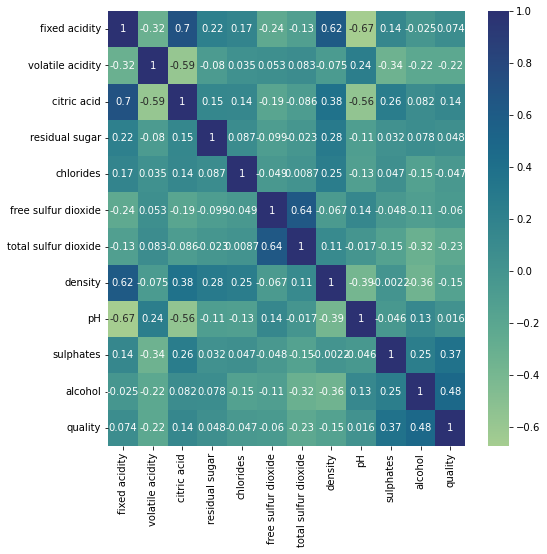

In [9]:
corr = X
corr['quality']=y
corr = corr.corr()

fig, ax = plt.subplots(figsize=(8,8)) 
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           annot=True,
           ax=ax,
           cmap="crest")

In [56]:
p_val = pd.DataFrame(f_regression(x, y)).T.rename({0:'F-stat', 1:'p-val'}, axis=1)
p_val['col'] = list(x)
p_val.sort_values('p-val', ascending=False)

D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


,F-stat,p-val,col
9,0.551111,4.579489e-01,pH
5,4.474743,3.451947e-02,chlorides
4,4.774201,2.900190e-02,residual sugar
6,7.475191,6.309181e-03,free sulfur dioxide
1,11.264121,8.045900e-04,fixed acidity
3,42.146157,1.058962e-10,citric acid
8,49.365367,2.878620e-12,density
2,103.759674,8.317343e-24,volatile acidity
7,110.217403,3.757538e-25,total sulfur dioxide
10,319.589363,1.509245e-66,sulphates


In [59]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

x = add_constant(X)
model = OLS(y, x).fit()
pvalues = pd.DataFrame(model.pvalues)
pvalues.reset_index(inplace=True)
pvalues.rename(columns={0: "pvalue", "index": "feature"}, inplace=True)
pvalues.style.background_gradient(cmap='YlOrRd')

D:\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,pvalue
0,const,0.025534
1,fixed acidity,0.020765
2,volatile acidity,0.264205
3,citric acid,0.741096
4,residual sugar,0.495016
5,chlorides,0.861593
6,free sulfur dioxide,0.003011
7,total sulfur dioxide,0.000198
8,density,0.031832
9,pH,0.565406


In [65]:
cols_matter = ['fixed acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'sulphates']

In [8]:
#modeling

In [ ]:
rf = RandomForestClassifier(criterion='entropy')
parametrs = {'n_estimators':range(60, 80, 4),
            'max_depth':range(1, 30, 6),
            'min_samples_split':range(5, 56, 10),
            'min_samples_leaf':range(2, 11, 2)}
search = GridSearchCV(rf, parametrs, cv=3, n_jobs=-1)
search.fit(X_train, y_train)
model = search.best_estimator_
prediction = model.predict(X_test)
score = cohen_kappa_score(y_test, prediction)

In [130]:
rf = RandomForestClassifier(criterion='entropy')
parametrs = {'n_estimators':range(60, 80, 4),
            'max_depth':range(1, 30, 6),
            'min_samples_split':range(5, 56, 10),
            'min_samples_leaf':range(2, 11, 2)}
search = GridSearchCV(rf, parametrs, cv=3, n_jobs=-1)
search.fit(X_train, y_train)
model = search.best_estimator_
prediction = model.predict(X_test)
score = cohen_kappa_score(y_test, prediction)

In [18]:
results = pd.DataFrame(columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'score'])
for n_estimators in range(48, 49, 2):
    for max_depth in range(20, 100, 1):
        for min_samples_split in range(100, 101):
            for min_samples_leaf in range(40, 41):
                rf = RandomForestClassifier(criterion='entropy',
                                            n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            min_samples_leaf=min_samples_leaf)
                rf.fit(X_train, y_train)
                prediction = rf.predict(X_test)
                score = cohen_kappa_score(y_test, prediction)
                
                pred_df = pd.DataFrame({'n_estimators':[n_estimators],
                              'max_depth':[max_depth],
                              'min_samples_split':[min_samples_split],
                              'min_samples_leaf':[min_samples_leaf],
                              'score':[score]})
                results = results.append(pred_df, ignore_index = True)
results.sort_values('score',ascending=False).head()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,score
68,48,88,100,40,0.288464
79,48,99,100,40,0.286339
19,48,39,100,40,0.282035
36,48,56,100,40,0.280866
59,48,79,100,40,0.278363


In [23]:
best_model_so_far = RandomForestClassifier(n_estimators=31, max_depth=90, min_samples_split=5, min_samples_leaf=5)
best_model_so_far.fit(X_train, y_train)
prediction = best_model_so_far.predict(X_test)
cohen_kappa_score(y_test, prediction)

0.29740277804293347

In [63]:
#results_svc = pd.DataFrame(columns=['C', 'score'])
#for C in range(1,2):
svc = SVC(C=1000, kernel='poly')
svc.fit(X_train, y_train)
prediction = svc.predict(X_test)
score = cohen_kappa_score(y_test, prediction)
#
#pred_df = pd.DataFrame({'C': [C],
#                        'score':[score]})
#results_svc = results_svc.append(pred_df, ignore_index = True)
#results_svc

In [65]:
score

0.26395906289170024

In [17]:
results_dt = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'min_samples_leaf', 'score'])
for max_depth in range(100, 201, 1):
    for min_samples_split in range(100, 101):
        for min_samples_leaf in range(40, 41):
            dt = DecisionTreeClassifier(criterion='entropy',
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf)
            dt.fit(X_train, y_train)
            prediction = dt.predict(X_test)
            score = cohen_kappa_score(y_test, prediction)
            
            pred_df = pd.DataFrame({'max_depth':[max_depth],
                          'min_samples_split':[min_samples_split],
                          'min_samples_leaf':[min_samples_leaf],
                          'score':[score]})
            results_dt = results_dt.append(pred_df, ignore_index = True)
results_dt.sort_values('score',ascending=False).head()

,max_depth,min_samples_split,min_samples_leaf,score
0,100,100,40,0.284376
64,164,100,40,0.284376
74,174,100,40,0.284376
73,173,100,40,0.284376
72,172,100,40,0.284376


In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
cohen_kappa_score(y_test, lr.predict(X_test))

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.24036602337524782

In [260]:
class_trashold = [3.4, 4.4, 5.5, 6.6, 7.7]
class_trashold = [x - 0.00 for x in class_trashold]
class_trashold

[3.4, 4.4, 5.5, 6.6, 7.7]

In [17]:
lr = LinearRegression()
X_train_log = X_train[cols_matter]
X_test_log = X_test[cols_matter]
lr.fit(X_train, y_train)
trashold_df = pd.DataFrame(columns=['x', 'score'])
for a in range(-100, 101, 1):
    class_trashold = [3.5, 4.5, 5.5, 6.5, 7.5]
    class_trashold = [x + a/100.0 for x in class_trashold]
    prediction = lr.predict(X_test)
    i = 0
    for el in prediction:
        if (el < class_trashold[0]):
            prediction[i] = int(3)
        elif (el < class_trashold[1]):
            prediction[i] = int(4)
        elif (el < class_trashold[2]):
            prediction[i] = int(5)
        elif (el < class_trashold[3]):
            prediction[i] = int(6)
        elif (el < class_trashold[4]):
            prediction[i] = int(7)
        else:
            prediction[i] = int(8)
        i+=1
    prediction = [int(x) for x in prediction]
    score = cohen_kappa_score(y_test, prediction)
    trashold_df = trashold_df.append(pd.DataFrame({'x': [a/100], 'score': [score]}))
trashold_df.sort_values('score',ascending=False)

,x,score
0,-0.01,0.345260
0,-0.04,0.340441
0,-0.03,0.339590
0,-0.02,0.339135
0,0.00,0.333752
...,...,...
0,0.98,-0.112295
0,0.96,-0.113821
0,0.97,-0.114522
0,1.00,-0.120457


In [74]:
def bin_data(series, bin_defs):
    bins = [0 for _ in range(len(bin_defs))]
    total = 0
    for x in series:
        for index, (bin_min, bin_max) in enumerate(bin_defs):
            if x >= bin_min and x < bin_max:
                bins[index] += 1
                total += 1
                break
    return [float(x / total) if total != 0 else 0 for x in bins]
bin_defs = []
labels = []
z = 5.0
for x in range(int(z), 46):
    bin_defs.append([z, z+0.25])
    labels.append("{:.2f} - {:.2f}".format(z, z+0.25))
    z += 0.25
bin_data(X[(X["quality"] == 3)]["fixed acidity"], bin_defs)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0

In [72]:
cols_matter = list(X_train)
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2023)

X_train_log = X_train[cols_matter]
X_test_log = X_test[cols_matter]
X = X[cols_matter]

train_oof_preds = np.zeros((X_train.shape[0],))

trashold_df = pd.DataFrame(columns=['a', 'b', 'c', 'score'])
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    
    X_train_sp, X_valid = pd.DataFrame(X_train.iloc[train_index]), pd.DataFrame(X_train.iloc[test_index])
    y_train_sp, y_valid = y_train.iloc[train_index], y_train.iloc[test_index]
    lgbm = LGBMRegressor(random_state=2023,
        metric="rmse",
        n_jobs=-1,
        n_estimators=1000,
        verbose=-1)
    
    lgbm.fit(X_train_sp, y_train_sp,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ])
    
    prediction = lgbm.predict(X_valid)
    train_oof_preds[test_index] = prediction
prediction_ar = np.zeros((train_oof_preds.shape[0],))

optimized_rounder = OptimizedRounder()
optimized_rounder.fit(train_oof_preds, y_train)
train_oof_preds_by_class = optimized_rounder.predict(train_oof_preds, optimized_rounder.coefficients())

for c in range(30, 41):
    for a in range(max(40, c+1), 51):
        for b in range(70, 81):
            class_trashold = [c/10, a/10, 5.6, 6.1, b/10]
            #class_trashold = [x + a/100.0 for x in class_trashold]
            i = 0
            for el in train_oof_preds:
                if (el < class_trashold[0]):
                    prediction_ar[i] = int(3)
                elif (el < class_trashold[1]):
                    prediction_ar[i] = int(4)
                elif (el < class_trashold[2]):
                    prediction_ar[i] = int(5)
                elif (el < class_trashold[3]):
                    prediction_ar[i] = int(6)
                elif (el < class_trashold[4]):
                    prediction_ar[i] = int(7)
                else:
                    prediction_ar[i] = int(8)
                i+=1
            score = cohen_kappa_score(y_train, prediction_ar, weights="quadratic")
            trashold_df = trashold_df.append(pd.DataFrame({'a': [a/100], 'b': [b/100], 'c': [c/100], 'score': [score]}))


QWE_by_class = cohen_kappa_score(y_train, train_oof_preds_by_class, weights="quadratic")
print(f'my QWE: {trashold_df.sort_values("score",ascending=False).iloc[0]["score"]}')
print(f'QWE by classes: {QWE_by_class}')


my QWE: 0.5626807157078965
QWE by classes: 0.5629912988660648


In [22]:
from functools import partial
import numpy as np
import scipy as sp

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [3.5, 4.5, 5.5, 6.5, 7.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8
        return X_p.astype('int')

    def coefficients(self):
        return self.coef_['x']

In [34]:
trashold_df.sort_values("score",ascending=False)

,a,b,c,score
0,0.49,0.56,0.61,0.569768
0,0.41,0.56,0.61,0.569687
0,0.47,0.56,0.61,0.569687
0,0.48,0.56,0.61,0.569687
0,0.40,0.56,0.61,0.569687
...,...,...,...,...
0,0.44,0.50,0.70,0.020881
0,0.41,0.50,0.70,0.020881
0,0.47,0.50,0.70,0.020881
0,0.42,0.50,0.70,0.020881


In [38]:
trashold_df.sort_values("score",ascending=False)

,a,b,c,score
0,0.49,0.75,0.40,0.569768
0,0.49,0.71,0.30,0.569768
0,0.49,0.73,0.39,0.569768
0,0.49,0.71,0.31,0.569768
0,0.49,0.73,0.40,0.569768
...,...,...,...,...
0,0.50,0.70,0.35,0.566084
0,0.50,0.70,0.39,0.566084
0,0.50,0.70,0.32,0.566084
0,0.50,0.70,0.34,0.566084
